## **Exploratory analysis for Nigeria flooding study**

In [1]:
import sys; sys.path.append('/home/clair/WWA'); from wwa import *

pr = xr.open_dataset("../01_chirps/chirps-daily-p25.nc").precip.sel(longitude = slice(-13,27), latitude = slice(0,25))

---
### **Maps of the study region**

#### **Catchment shapefiles**

In [245]:
# Niger-Benue catchment (originally didn't include the lvl4 area)
nb = pd.concat([gpd.read_file("hybas_af_lev01-12_v1c/lev03").to_crs(epsg = "4326").iloc[[15,16,17]],
                gpd.read_file("hybas_af_lev01-12_v1c/lev04").to_crs(epsg = "4326").iloc[[93]]]).dissolve().explode(index_parts = True).iloc[[3]]   # remove holes
nb.to_file("niger-benue-catchment")

# Lake Chad catchment
lc = gpd.read_file("hybas_af_lev01-12_v1c/lev03").to_crs(epsg = "4326").iloc[[39]]
lc.to_file("lake-chad-catchment")

# also save region around Lagdo dam - can we say anything about the need to open the dam?
gpd.read_file("hybas_af_lev01-12_v1c/lev05").loc[[407]].to_crs(epsg = "4326").to_file("lagdo-dam-catchment")

In [19]:
# extract lat & lon, save as points for easier upload to Climate Explorer
for fnm in ["niger-benue-catchment", "lake-chad-catchment"]:
    
    gdf = gpd.read_file(fnm)
    px = gdf.geometry[0].exterior.coords.xy
    pd.DataFrame(px, index = ["#lon", "lat"]).transpose().to_csv(fnm+"-latlon.txt", index = None, sep = " ")

#### **Map of catchments and affected states**

In [6]:
states = gpd.read_file("nigeria-lgas").to_crs(epsg = "4326")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# most affected LGAs, per the trigger
aff = ["Teungo", "Gujba", "Geidam", "Gulani", "Fufore", "Song", "Potiskum", "Nguru", "Jakusko", "Monguno", "Nangere", "Karasuwa"]   

# also mentioned in news stories
aff2 = list(set(["Lokoja", "Kolokuma/Opokuma", "Bayelsa", "Anambra", "Delta", "Cross River", "Rivers", "Edo", "Ebonyi", "Imo", "Abia", "Lagos", 
                 "Yobe", "Borno", "Taraba", "Adamawa", "Kogi", "Niger", "Plateau", "Benue", "Bauchi", "Gombe", "Kano", "Jigawa", "Zamfara", "Kebbi", "Sokoto", "Federal Capital Territory",
                 "Maradi", "Zinder", "Tillaberi", "Tahoua"]))

# (https://www.thisdaylive.com/index.php/2022/10/17/nema-2-5-million-persons-affected-by-flooding/)
    # Bayelsa State Governor, Senator Douye Diri has urged the federal government to declare a national emergency
    # States like Anambra, Delta, Cross River, Rivers and Bayelsa are still at risk of experiencing floods up till the end of November 
    # The only road that links Opokuma and Sabagreia in Kolokuma/Opokuma Local Government Area and the only one also connecting Sagbama to Ekeremor that is still under construction has been broken

# (https://von.gov.ng/nigerias-delegation-to-meet-with-cameroun-over-impending-flood/)
    # the Metrological Agencies are warning that States like Anambra, Delta, Cross River, Rivers and Bayelsa are still at risk of experiencing floods up till the end of November.

# (https://humanglemedia.com/over-half-a-million-people-in-nigeria-affected-by-floods-this-year/)
    # A more comprehensive statement from a senior aide revealed that 508,721 people were affected by flooding across the country, 
    # with incidents recorded in the southern states of Edo, Delta, Ebonyi, Anambra, Imo, Abia, and the economic hub of Lagos. 
    # In the country’s north, flooding was recorded in Yobe, Borno, Taraba, Adamawa, Kogi, Niger, Plateau, Benue, Bauchi, Gombe, Kano, Jigawa, Zamfara, Kebbi, Sokoto, and the Federal Capital Territory. 

# (https://dailypost.ng/2022/09/15/over-300-people-killed-by-flood-in-nigeria-in-2022-alone-sci/)
    # since early July, intense rainfall has affected communities along the Niger-Nigeria border, triggering flooding which has washed away or damaged at least 14,900 homes
    # torrential rains are expected to continue in southern Niger and Northern Nigeria until the end of September
    # It noted that the flooding has also wreaked havoc in Niger’s Maradi, Zinder, Tillaberi and Tahoua regions, with more than 100,000 people affected in Niger alone.
    # SCI added that in Nigeria, flooding has also wreaked havoc in Borno, Yobe, and Adamawa States.
    
# (https://reliefweb.int/disaster/fl-2022-000271-nga)
    # Tounga, Fufore LGAs in Adamawa state and Gujba, Geidam, and Gulani LGA in Yobe state have been the most affected areas by the floods, according to partners’ rapid needs assessments
    

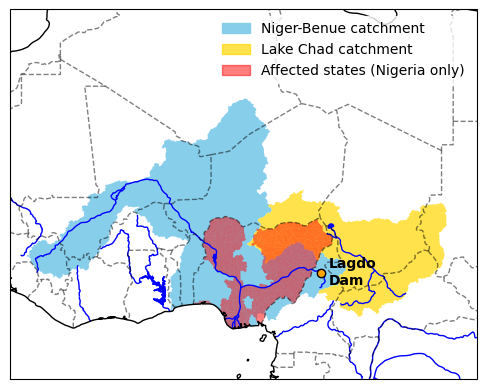

In [426]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)
gpd.read_file("niger-benue-catchment").plot(ax = ax, color = "skyblue")
gpd.read_file("lake-chad-catchment").plot(ax = ax, color = "gold", alpha = 0.7)

[states.loc[states.STATE == aff2[i]].plot(ax = ax, color = "red", alpha = 0.5) for i in range(len(aff2)) if aff2[i] in states.STATE.values]      # mentioned at state level

ax.add_feature(cartopy.feature.RIVERS, color = "blue")
ax.add_feature(cartopy.feature.LAKES, color = "blue")
ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.coastlines()
ax.set_extent((-13,27,0,30))

ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
ax.annotate("Lagdo\nDam", xy = get_latlon("Lagdo Dam").values(), fontweight = "bold", textcoords="offset points", xytext=(5,-8), ha='left')

legend_items = [{"label" : "Niger-Benue catchment", "color" : "skyblue", "alpha" : 1},
                {"label" : "Lake Chad catchment", "color" : "gold", "alpha" : 0.7},
                {"label" : "Affected states (Nigeria only)", "color" : "red", "alpha" : 0.5}]

plt.legend(handles = [matplotlib.patches.Patch(color = l["color"], alpha = l["alpha"], label= l["label"]) for l in legend_items], edgecolor = "w")

plt.savefig("niger-benue-chad_catchment-with-affected-areas.png")

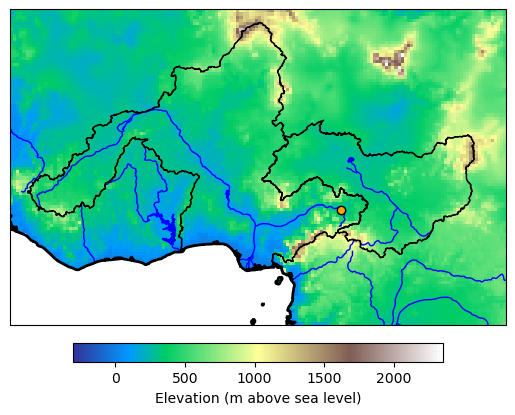

In [428]:
# elevations within Niger-Benue catchment
elev = xr.open_dataset("../90_data/elevation-0.25deg-global.nc").elev

# mask land surface
lsm = regionmask.mask_3D_geopandas(gpd.read_file("hybas_af_lev01-12_v1c/lev01"), elev.lon, elev.lat, drop = False).squeeze(drop = True)
elev = elev.where(lsm).dropna("lat", "all").dropna("lon", "all").sel(lat = slice(0,25), lon = slice(-13,27))

elev.plot(center = False, cmap = "terrain", subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
          cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05, "label" : "Elevation (m above sea level)"})
ax = plt.gcf().axes[0]
gpd.read_file("niger-benue-catchment").boundary.plot(ax = ax, color = "k", lw = 1)
gpd.read_file("lake-chad-catchment").boundary.plot(ax = ax, color = "k", lw = 1)

# add more detailed rivers
# rv = gpd.read_file("africa-rivers").to_crs(epsg = "4326").clip(pd.concat([gpd.read_file("niger-benue-catchment"), gpd.read_file("lake-chad-catchment")]))
# rv.plot(ax = ax, lw = 1, color = "darkblue")

ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")

ax.add_feature(cartopy.feature.RIVERS, color = "blue")
ax.add_feature(cartopy.feature.LAKES, color = "blue")

ax.coastlines(lw = 2)

plt.savefig("niger-benue-chad_topography.png", dpi = 100)

#### **Sub-catchments**

In [168]:
nb = gpd.read_file("niger-benue-catchment")
l2 = gpd.read_file("hybas_af_lev01-12_v1c/lev02").clip(nb)
l3 = gpd.read_file("hybas_af_lev01-12_v1c/lev03").clip(nb)
l4 = gpd.read_file("hybas_af_lev01-12_v1c/lev04").clip(nb)
l5 = gpd.read_file("hybas_af_lev01-12_v1c/lev05").clip(nb)
l6 = gpd.read_file("hybas_af_lev01-12_v1c/lev06").clip(nb)
l7 = gpd.read_file("hybas_af_lev01-12_v1c/lev07").clip(nb)

niger_delta = pd.concat([l5.loc[(l5.centroid.y <= 6) & (l5.centroid.x <= 8) & (l5.geom_type.str.contains("Polygon"))],
                         l7.loc[(l7.centroid.y <= 6) & (l7.centroid.x >= 6) & (l7.centroid.x <= 7) & (l7.geom_type.str.contains("Polygon"))]]).dissolve()
upper_niger = l5.loc[(l5.centroid.x <= -3) & (l5.centroid.y <= 13.5)].dissolve()
abonyi = l5.loc[[381]].dissolve()
inland_delta = l6.loc[(l6.centroid.y >= 13.5) & (l6.centroid.x <= -3) & (l6.geom_type.str.contains("Polygon"))].dissolve()
lower_niger = pd.concat([l7.loc[(l7.centroid.y >= 6) & (l7.centroid.y <= 8) & (l7.centroid.x >= 6) & (l7.centroid.x <= 7.5)],
                         l4.loc[(l4.centroid.y >= 8) & (l4.centroid.y <= 11.5) & (l4.centroid.x >= 2) & (l4.centroid.x <= 12)]]).dissolve()
middle_niger = pd.concat([l6.loc[(l6.centroid.y >= 10.5) & (l6.centroid.x >= -3) & (l6.centroid.x <= 3) & (l6.geom_type.str.contains("Polygon"))],
                          l4.loc[(l4.centroid.x >= 2.5) & (l4.centroid.x <= 7) & (l4.centroid.y >= 10.5) & (l4.geom_type.str.contains("Polygon"))]]).dissolve()

nb_sub = pd.concat([upper_niger, inland_delta, middle_niger, lower_niger, niger_delta, abonyi])
nb_sub["REGION"] = ["Upper Niger", "Inland Delta", "Middle Niger", "Lower Niger", "Niger Delta", "Abonyi"]
nb_sub.to_file("niger-benue-subcatchments")

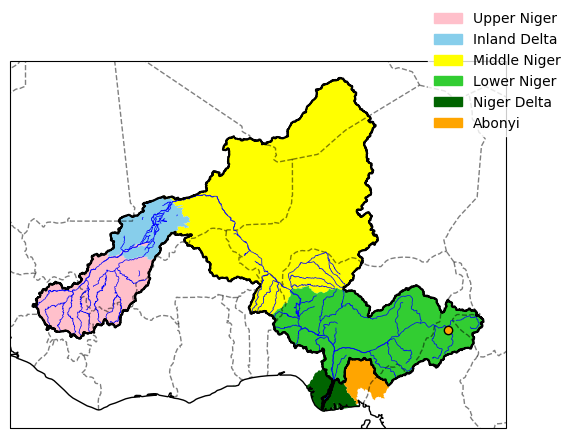

In [387]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)

upper_niger.plot(ax = ax, color = "pink")
middle_niger.plot(ax = ax, color = "yellow")
niger_delta.plot(ax = ax, color = "darkgreen")
abonyi.plot(ax = ax, color = "orange")
inland_delta.plot(ax = ax, color = "skyblue")
lower_niger.plot(ax = ax, color = "limegreen")

rv.loc[rv.RIVERS_ID <= 5.0].plot(ax = ax, color = "blue", lw = 0.5)

ax.add_feature(cartopy.feature.BORDERS, color = "k", alpha = 0.5, ls = "--")
ax.coastlines()

fig.legend(handles = [matplotlib.patches.Patch(color = c, label = l) for c,l in zip(["pink", "skyblue", "yellow", "limegreen", "darkgreen", "orange"],
                                                                                    ["Upper Niger", "Inland Delta", "Middle Niger", "Lower Niger", "Niger Delta", "Abonyi"])], 
           edgecolor = "w")

nb.boundary.plot(ax = ax, color = "k")
ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")


plt.savefig("niger-benue-subcatchments.png")

In [217]:
pr = xr.open_dataset("../01_chirps/chirps-daily-p25.nc").precip.sel(longitude = slice(-13,27), latitude = slice(0,25))

# get daily mean precip in each sub-catchment

pr_c = {k : pr.where(regionmask.mask_3D_geopandas(eval(k), pr.longitude, pr.latitude).squeeze(drop = True)).mean(["latitude", "longitude"]) for k in ["upper_niger", "inland_delta", "middle_niger", "lower_niger", "niger_delta", "abonyi"]}

In [218]:
labelticks = [i for i in range(366) if pr.sel(time = slice("20180101", "20190101")).time.dt.day[i] == 1]
labels = [pr.sel(time = slice("20180101", "20190101")).time[i].values for i in range(366) if pr.sel(time = slice("20180101", "20190101")).time.dt.day[i] == 1]

colours = ["orchid", "skyblue", "gold", "yellowgreen", "darkgreen", "orange"]

In [225]:
sf = gpd.read_file("hybas_af_lev01-12_v1c/lev03").to_crs(epsg = "4326").iloc[[16]]
pr_nb = pr.where(regionmask.mask_3D_geopandas(sf, pr.longitude, pr.latitude).squeeze(drop = True)).mean(["latitude", "longitude"])

In [229]:
for ndays in [1,3,5,7,15,30,60,90,120]:
    
    fig, axs = plt.subplots(figsize = (6,4), dpi = 100, sharey = False)
    
    for i in range(1):
        ax = plt.gcf().axes[i]
        cmt = list(pr_c.keys())[i]
        ts = pr_nb.rolling(time = ndays, center = False).mean()
        
        # plot each year individually so that the overlapping transparencies interact
        for y in set(ts.time.dt.year.values): 
            ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3)
        ax.plot(ts.sel(time = "2022").time.dt.dayofyear, ts.sel(time = "2022"), color = "k", label = "2022")
        ax.legend(edgecolor = "w")
        
        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b"))
        ax.set_ylabel("Mean daily rate (mm/day)")
        ax.grid(axis = "x", alpha = 0.5, ls = "--")
        
    # axs[2].axvline(pr_lagdo.sel(time = "20180920").time.dt.dayofyear.values, ls = "--", color = "red", alpha = 0.4) # opening of the dam
    
    fig.suptitle("Mean daily rate of "+str(ndays)+"-day accumulated precipitation in 2022 compared to previous years", fontweight = "bold", y = 1.02)
    plt.savefig("smaller_catchment_"+str(ndays)+"-day-precip.png"); plt.close()

In [219]:
for ndays in [1,3,5,7,15,30,60,90,120]:
    
    fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (16,8), dpi = 100, sharey = False)
    
    for i in range(6):
        ax = plt.gcf().axes[i]
        cmt = list(pr_c.keys())[i]
        ts = pr_c[cmt].rolling(time = ndays, center = False).mean()
        
        # plot each year individually so that the overlapping transparencies interact
        for y in set(ts.time.dt.year.values): 
            ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = colours[i], alpha = 0.3)
        ax.plot(ts.sel(time = "2022").time.dt.dayofyear, ts.sel(time = "2022"), color = "k", label = "2022")
        ax.legend(edgecolor = "w")
        ax.set_title(cmt)
        
        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b"))
        ax.set_ylabel("Mean daily rate (mm/day)")
        ax.grid(axis = "x", alpha = 0.5, ls = "--")
        
    # axs[2].axvline(pr_lagdo.sel(time = "20180920").time.dt.dayofyear.values, ls = "--", color = "red", alpha = 0.4) # opening of the dam
    
    fig.suptitle("Mean daily rate of "+str(ndays)+"-day accumulated precipitation in 2022 compared to previous years", fontweight = "bold", y = 1.02)
    plt.savefig("subcatchments_"+str(ndays)+"-day-precip.png"); plt.close()

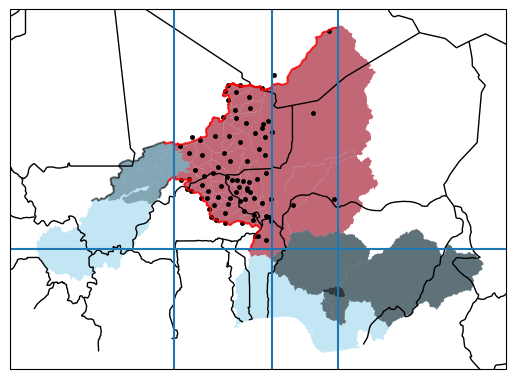

In [166]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)

sub = pd.concat([l6.loc[(l6.centroid.y >= 10.5) & (l6.centroid.x >= -3) & (l6.centroid.x <= 3)],
                 l4.loc[(l4.centroid.x >= 2.5) & (l4.centroid.x <= 7) & (l4.centroid.y >= 10.5)]])

sub.plot(ax = ax, color = "red", marker = "")
                
inland_delta.plot(ax = ax, color = "k", alpha = 0.5)

nb.plot(ax = ax, color = "skyblue", alpha = 0.5)

# l4.boundary.plot(ax = ax, color = "k", marker = "", lw = 2)
# l4.boundary.plot(ax = ax, color = "red", marker = "", lw = 2)

sub.centroid.plot(ax = ax, color = "k", marker = ".", lw = 0.5)
lower_niger.plot(ax = ax, color = "k", alpha = 0.5)

# l2.boundary.plot(ax = ax, color = "darkred", marker = "")
ax.add_feature(cartopy.feature.BORDERS, color = "k", lw = 1)
ax.axvline(-3); ax.axvline(3); ax.axvline(7); 
ax.axhline(10.5);

#### **Nigeria**

In [65]:
nb = gpd.read_file("hybas_af_lev01-12_v1c/lev03").to_crs(epsg = "4326").iloc[[16]]
states = gpd.read_file("nigeria-lgas").to_crs(epsg = "4326")
lagdo_dam = gpd.read_file("hybas_af_lev01-12_v1c/lev05").loc[[407]].to_crs(epsg = "4326")
lake_chad = gpd.read_file("lake-chad-catchment")
rv = gpd.read_file("africa-rivers").to_crs(epsg = "4326").clip(pd.concat([nb, lake_chad]))
nb_sub = gpd.read_file("niger-benue-subcatchments")

nb_nigeria = pd.concat([states.clip(nb), gpd.read_file("hybas_af_lev01-12_v1c/lev04").loc[[93,98]]]).dissolve()
nb_nigeria.to_file("nigeria-catchment")

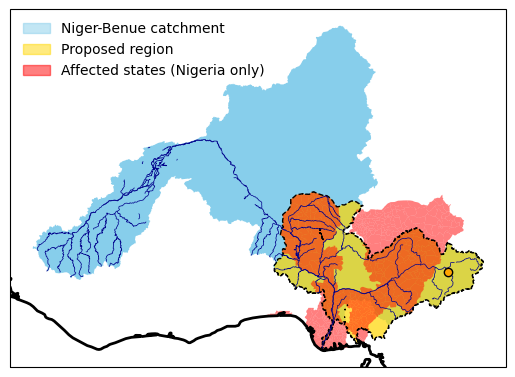

In [60]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)

nb.plot(ax = ax, color = "skyblue")

nb_nigeria.plot(ax = ax, color = "gold", alpha = 0.7)
nb_nigeria.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--")

rv.loc[rv.RIVERS_ID <= 6.0].clip(nb).plot(ax = ax, color = "darkblue", lw = 0.5)

[states.loc[states.STATE == aff2[i]].plot(ax = ax, color = "red", alpha = 0.5) for i in range(len(aff2)) if aff2[i] in states.STATE.values]      # impacts at state level

ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")

ax.coastlines(lw = 2)

plt.legend(handles = [matplotlib.patches.Patch(color = c, label = l, alpha = 0.5) for c,l in zip(["skyblue", "gold", "red"], ["Niger-Benue catchment", "Proposed region", "Affected states (Nigeria only)"])], 
           edgecolor = "w", loc = "upper left")

plt.savefig("revised-catchment.png")

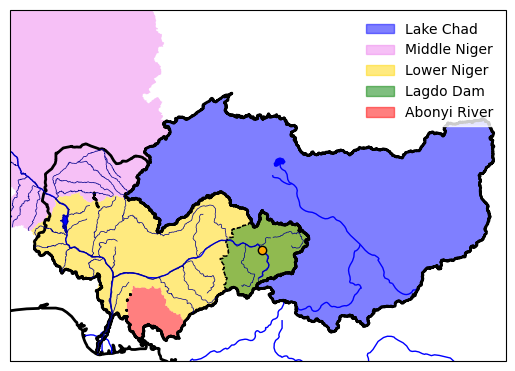

In [105]:
fig, ax = plt.subplots(subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)

nb_nigeria.boundary.plot(ax = ax, color = "k", lw = 2)
lake_chad.boundary.plot(ax = ax, color = "k", lw = 2)
lagdo_dam.boundary.plot(ax = ax, color = "k", lw = 1, ls = "--")

lake_chad.plot(ax = ax, color = "blue", alpha = 0.5)
nb_sub.loc[nb_sub.REGION == "Abonyi"].plot(ax = ax, color = "red", alpha = 0.5)
nb_sub.loc[nb_sub.REGION == "Lower Niger"].plot(ax = ax, color = "gold", alpha = 0.5)
nb_sub.loc[nb_sub.REGION == "Middle Niger"].plot(ax = ax, color = "violet", alpha = 0.5)
lagdo_dam.plot(ax = ax, color = "forestgreen", alpha = 0.5)

rv.loc[rv.RIVERS_ID <= 5.0].clip(nb).plot(ax = ax, color = "darkblue", lw = 0.5)

ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")

ax.coastlines(lw = 2)
ax.set_extent((2,25,4,20))

plt.legend(handles = [matplotlib.patches.Patch(color = c, label = l, alpha = 0.5) for c,l in zip(["blue", "violet", "gold", "green", "red"], 
                                                                                                 ["Lake Chad", "Middle Niger", "Lower Niger", "Lagdo Dam", "Abonyi River"])], 
           edgecolor = "w", loc = "upper right")

ax.add_feature(cartopy.feature.RIVERS, color = "blue")
ax.add_feature(cartopy.feature.LAKES, color = "blue")

plt.savefig("chad-nigeria-lagdo-regions.png")

In [388]:
sf = gpd.read_file("nigeria-catchment")
pr_nb = pr.where(regionmask.mask_3D_geopandas(sf, pr.longitude, pr.latitude).squeeze(drop = True)).mean(["latitude", "longitude"])

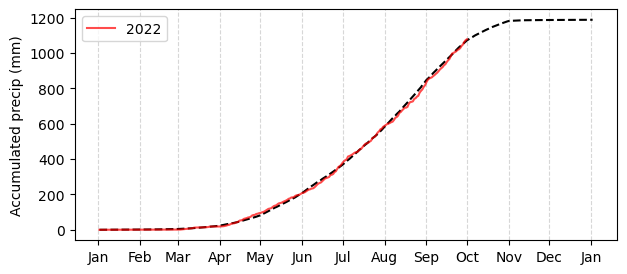

In [390]:
fig, ax = plt.subplots(figsize = (7,3), dpi = 100)

plt.plot()

ax.plot(pr_nb.sel(time = "2020").time.dt.dayofyear, pr_nb.sel(time = slice("1985", "2015")).groupby("time.dayofyear").mean().cumsum("dayofyear"),
        color = "k", ls = "--")

ax.plot(pr_nb.sel(time = "2022").time.dt.dayofyear, pr_nb.sel(time = "2022").cumsum("time"), color = "red", alpha = 0.7,  label = "2022")

ax.set_ylabel("Accumulated precip (mm)")

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b"))
ax.grid(axis = "x", alpha = 0.5, ls = "--")

plt.legend()

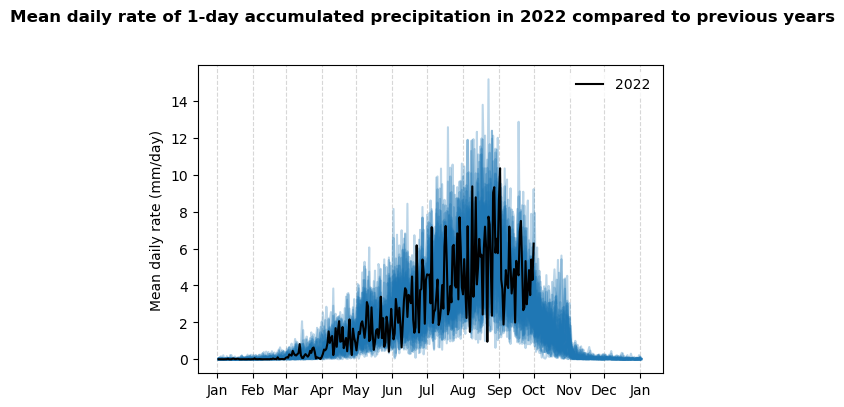

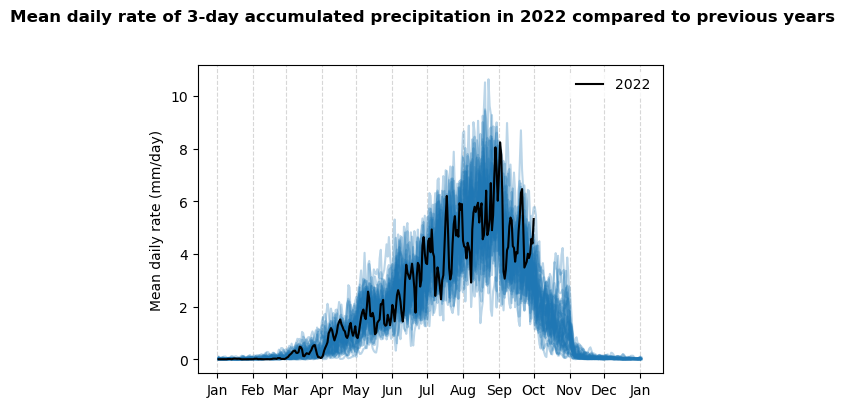

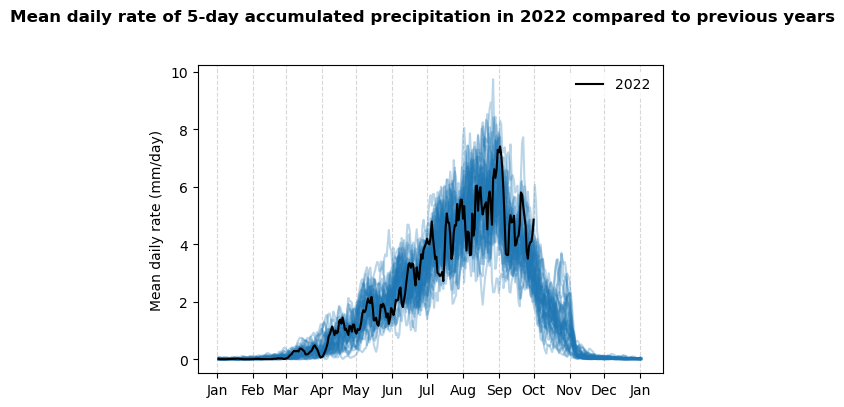

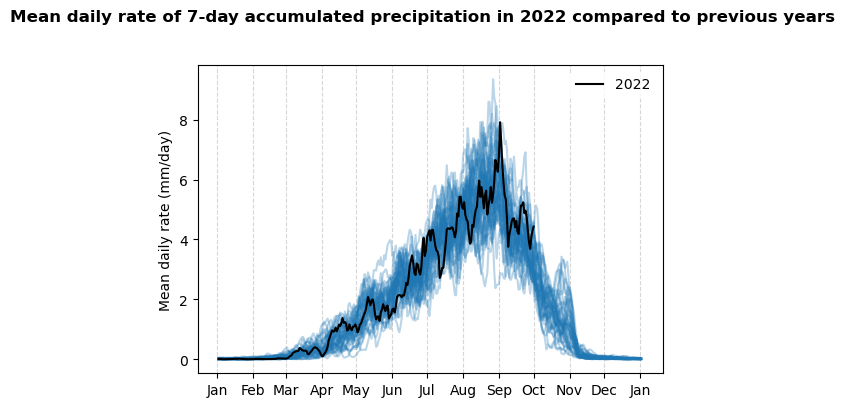

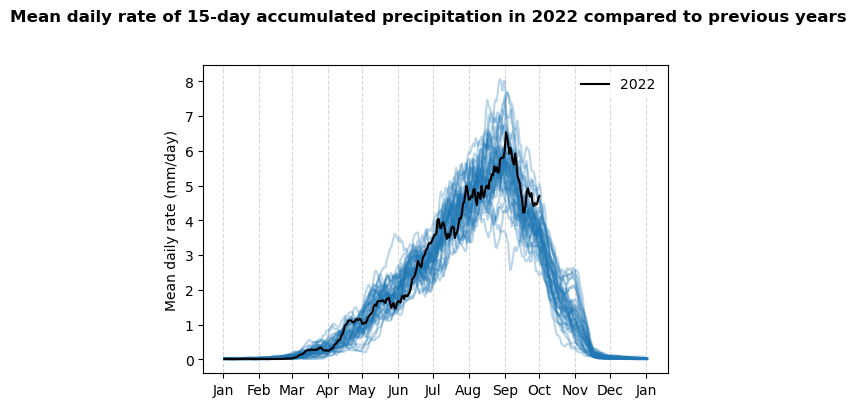

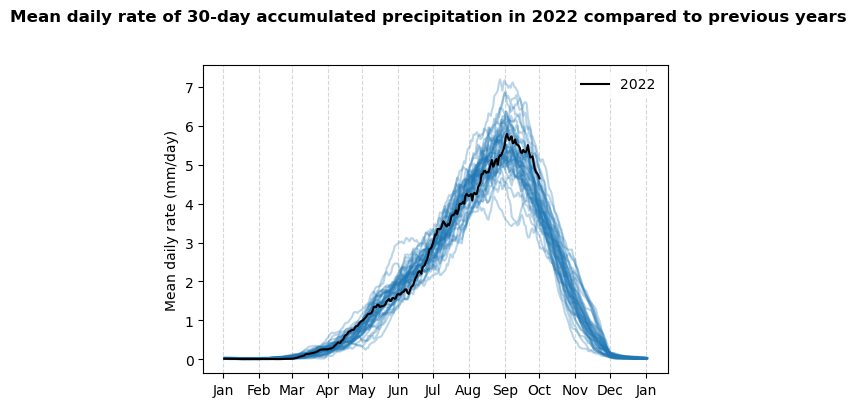

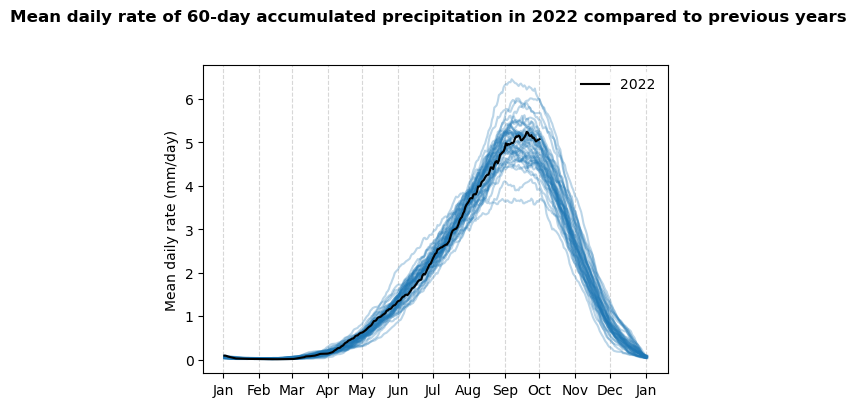

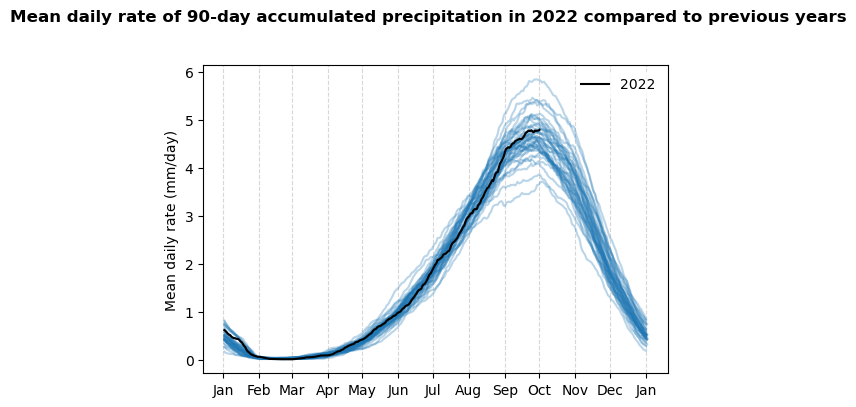

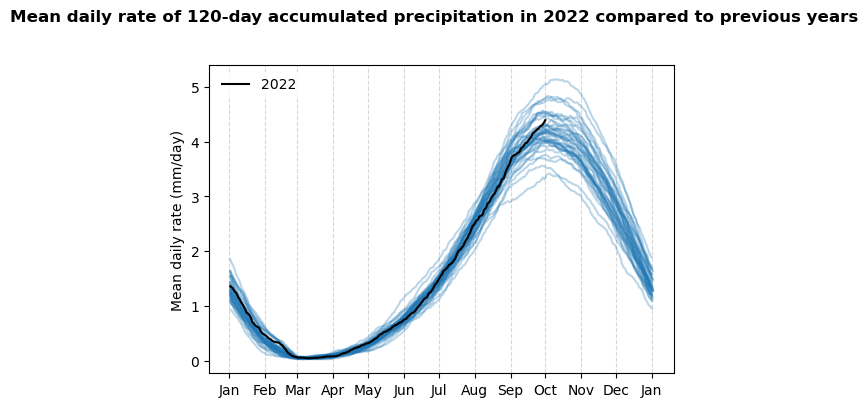

In [360]:
for ndays in [1,3,5,7,15,30,60,90,120]:
    
    fig, axs = plt.subplots(figsize = (6,4), dpi = 100, sharey = False)
    
    for i in range(1):
        ax = plt.gcf().axes[i]
        cmt = list(pr_c.keys())[i]
        ts = pr_nb.rolling(time = ndays, center = False).mean()
        
        # plot each year individually so that the overlapping transparencies interact
        for y in set(ts.time.dt.year.values): 
            ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3)
        ax.plot(ts.sel(time = "2022").time.dt.dayofyear, ts.sel(time = "2022"), color = "k", label = "2022")
        ax.legend(edgecolor = "w")
        
        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b"))
        ax.set_ylabel("Mean daily rate (mm/day)")
        ax.grid(axis = "x", alpha = 0.5, ls = "--")
        
    # axs[2].axvline(pr_lagdo.sel(time = "20180920").time.dt.dayofyear.values, ls = "--", color = "red", alpha = 0.4) # opening of the dam
    
    fig.suptitle("Mean daily rate of "+str(ndays)+"-day accumulated precipitation in 2022 compared to previous years", fontweight = "bold", y = 1.02)
    # plt.savefig("smaller_catchment_"+str(ndays)+"-day-precip.png"); plt.close()

### **TAMSAT**

In [381]:
pr = xr.open_mfdataset("../02_tamsat/tamsat_*_rfe-filled_0.25.v3.1.nc").rfe_filled.sel(lat = slice(0,25), lon = slice(-13,27))
sf = gpd.read_file("nigeria-catchment")
pr_nb = pr.where(regionmask.mask_3D_geopandas(sf, pr.lon, pr.lat).squeeze(drop = True)).mean(["lat", "lon"]).load()

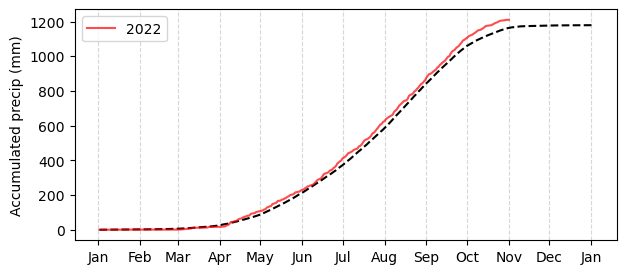

In [382]:
fig, ax = plt.subplots(figsize = (7,3), dpi = 100)

plt.plot()

ax.plot(pr_nb.sel(time = "1988").time.dt.dayofyear, pr_nb.sel(time = slice("1985", "2015")).groupby("time.dayofyear").mean().cumsum("dayofyear"),
        color = "k", ls = "--")

ax.plot(pr_nb.sel(time = "2022").time.dt.dayofyear, pr_nb.sel(time = "2022").cumsum("time"), color = "red", alpha = 0.7,  label = "2022")

ax.set_ylabel("Accumulated precip (mm)")

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b"))
ax.grid(axis = "x", alpha = 0.5, ls = "--")

plt.legend()

Text(0.5, 1.02, 'Mean daily rate of 120-day accumulated precipitation in 2022 compared to previous years')

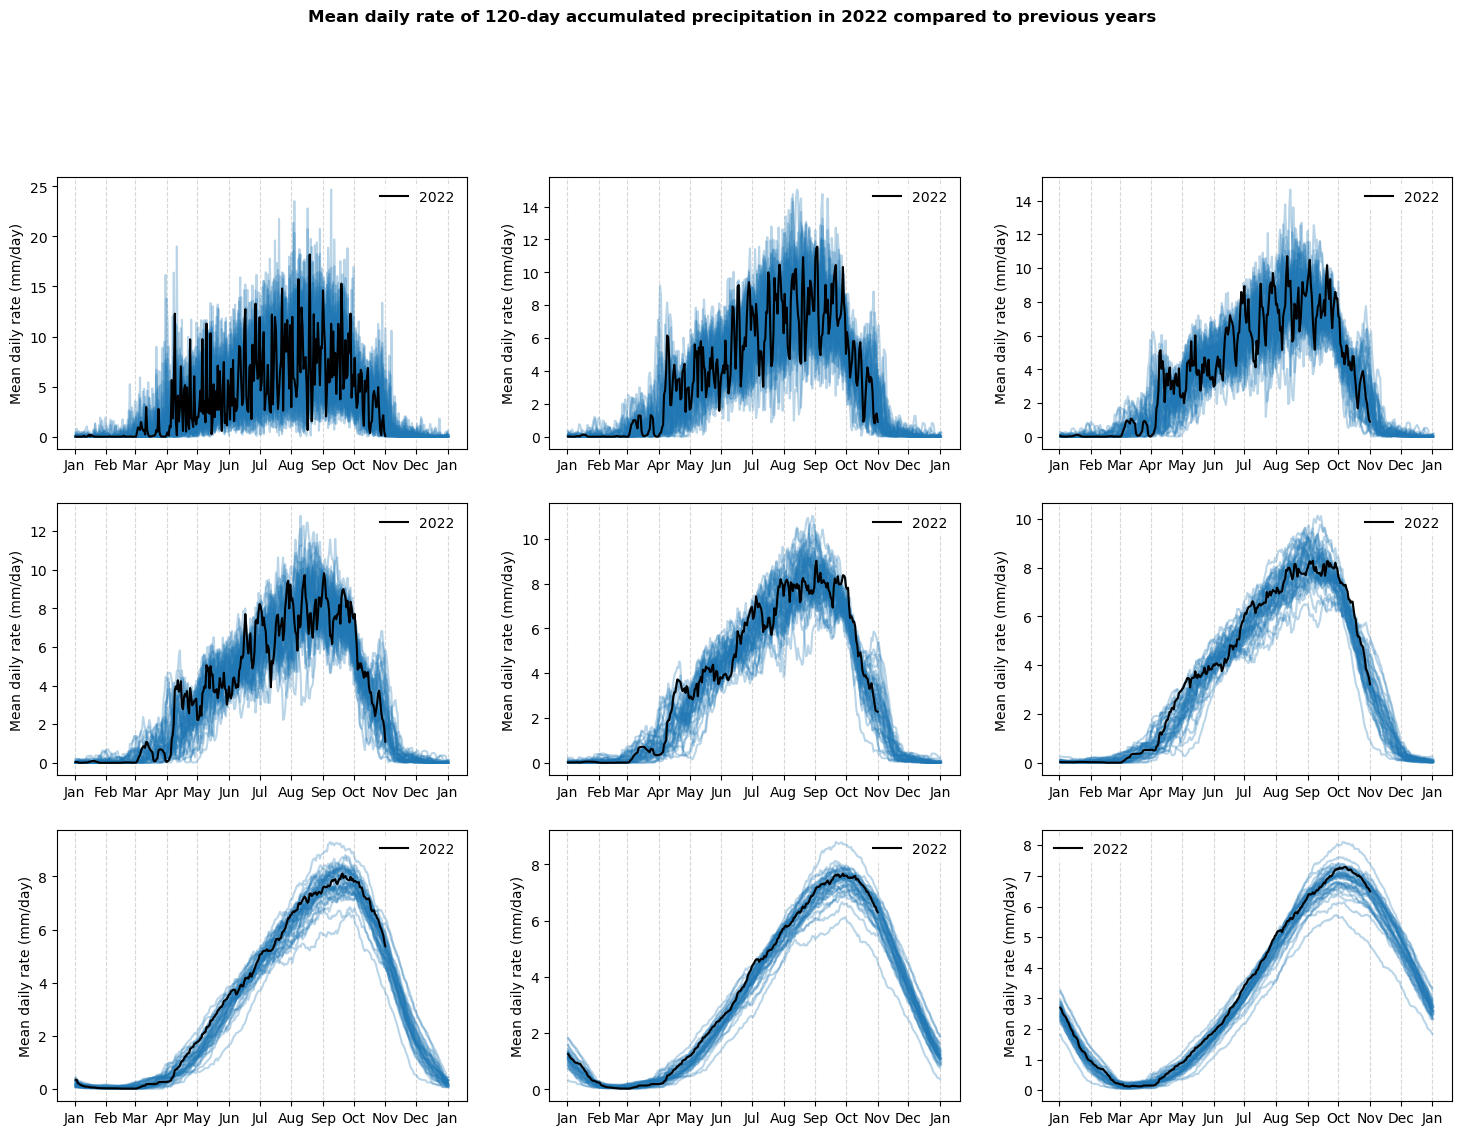

In [383]:
fig, axs = plt.subplots(ncols = 3, nrows = 3, figsize = (18,12), dpi = 100, sharey = False)

for ndays in [1,3,5,7,15,30,60,90,120]:
    
    i = [1,3,5,7,15,30,60,90,120].index(ndays)
    ax = plt.gcf().axes[i]
    ts = pr_nb.rolling(time = ndays, center = False).mean()
    
    # plot each year individually so that the overlapping transparencies interact
    for y in set(ts.time.dt.year.values): 
        ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3)
    ax.plot(ts.sel(time = "2022").time.dt.dayofyear, ts.sel(time = "2022"), color = "k", label = "2022")
    ax.legend(edgecolor = "w")
    
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b"))
    ax.set_ylabel("Mean daily rate (mm/day)")
    ax.grid(axis = "x", alpha = 0.5, ls = "--")
        
# axs[2].axvline(pr_lagdo.sel(time = "20180920").time.dt.dayofyear.values, ls = "--", color = "red", alpha = 0.4) # opening of the dam
    
fig.suptitle("Mean daily rate of "+str(ndays)+"-day accumulated precipitation in 2022 compared to previous years", fontweight = "bold", y = 1.02)
    # plt.savefig("smaller_catchment_"+str(ndays)+"-day-precip.png"); plt.close()

---
### **Maps of 2022 JJA/JJAS anomalies**

#### **Monthly anomalies**

In [ ]:
# individual monthly anomalies
pr =  xr.open_dataset("chirps-nigerbenue-monthly.nc").precip.sel(latitude = slice(0,25), longitude = slice(-13,27)).assign_attrs(long_name = "CHIRPS precipitation")

pr_clim = pr.sel(time = slice("1985", "2015")).groupby("time.month").mean()
pr_anom = (pr.groupby("time.month") - pr_clim).assign_attrs(long_name = "Absolute anomaly")
pr_rel = (pr_anom.groupby("time.month") / pr_clim * 100).assign_attrs(long_name = "Relative anomaly", units = "%")

In [ ]:
sf = pd.concat([gpd.read_file("niger-benue-catchment"), gpd.read_file("lake-chad-catchment")])
rm = regionmask.mask_3D_geopandas(sf.dissolve(), pr.longitude, pr.latitude, drop = False).squeeze(drop = True)

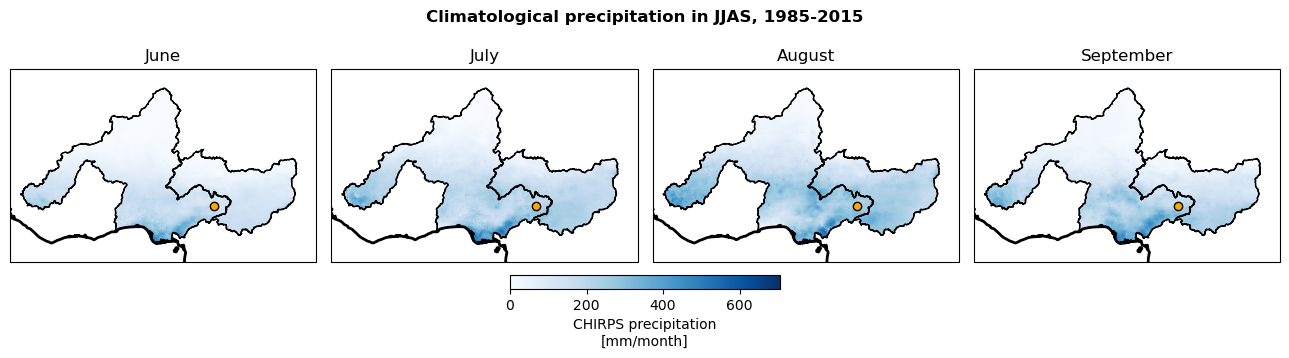

In [ ]:
pr_clim.sel(month = slice(6,9)).where(rm).plot(col = "month", cmap = "Blues",
                                                             subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
                                                             cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05})

for i in range(4):
    ax = plt.gcf().axes[i]
    ax.set_title(["June", "July", "August", "September"][i])
    sf.boundary.plot(ax = ax, lw = 1, color = "k")
    ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
    ax.set_extent((-13,27,2,25))
    ax.coastlines(lw = 2)
    
plt.gcf().suptitle("Climatological precipitation in JJAS, 1985-2015", fontweight = "bold")
plt.savefig("monthly-climatology.png")

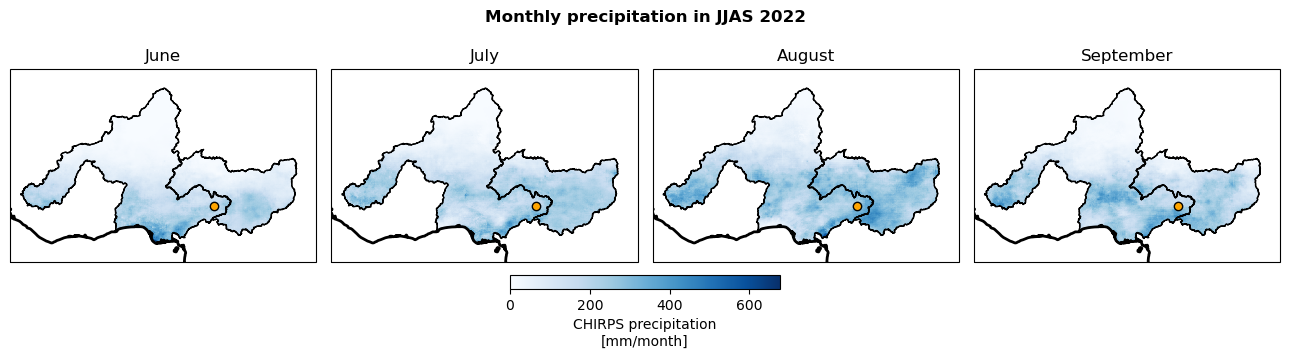

In [ ]:
pr.sel(time = slice("2022-06", "2022-09")).where(rm).plot(col = "time", cmap = "Blues",
                                                             subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
                                                             cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05})

for i in range(4):
    ax = plt.gcf().axes[i]
    ax.set_title(["June", "July", "August", "September"][i])
    sf.boundary.plot(ax = ax, lw = 1, color = "k")
    ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
    ax.set_extent((-13,27,2,25))
    ax.coastlines(lw = 2)
    
plt.gcf().suptitle("Monthly precipitation in JJAS 2022", fontweight = "bold")
plt.savefig("monthly-precipitation.png")

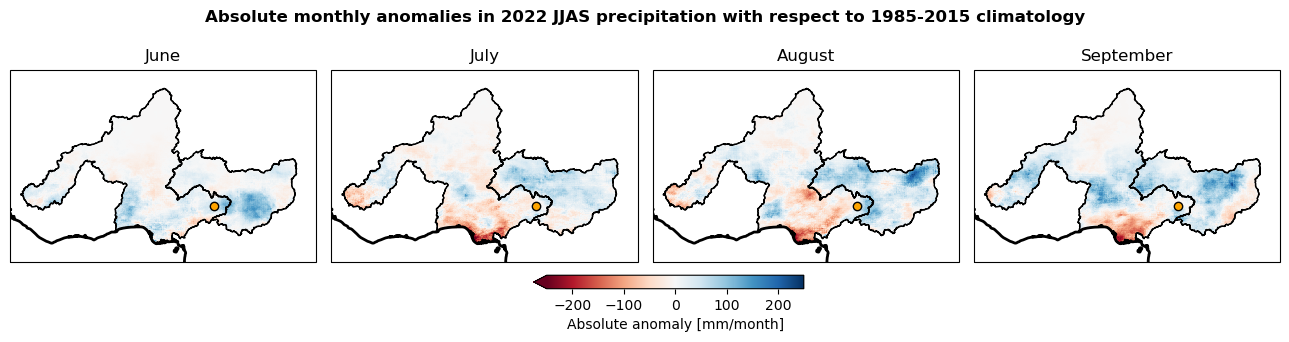

In [ ]:
pr_anom.sel(time = slice("2022-06", "2022-09")).where(rm).plot(col = "time", cmap = "RdBu", vmin = -250,
                                                             subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
                                                             cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05})

for i in range(4):
    ax = plt.gcf().axes[i]
    ax.set_title(["June", "July", "August", "September"][i])
    sf.boundary.plot(ax = ax, lw = 1, color = "k")
    ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
    ax.set_extent((-13,27,2,25))
    ax.coastlines(lw = 2)
    
plt.gcf().suptitle("Absolute monthly anomalies in 2022 JJAS precipitation with respect to 1985-2015 climatology", fontweight = "bold")
plt.savefig("monthly-anomalies.png")

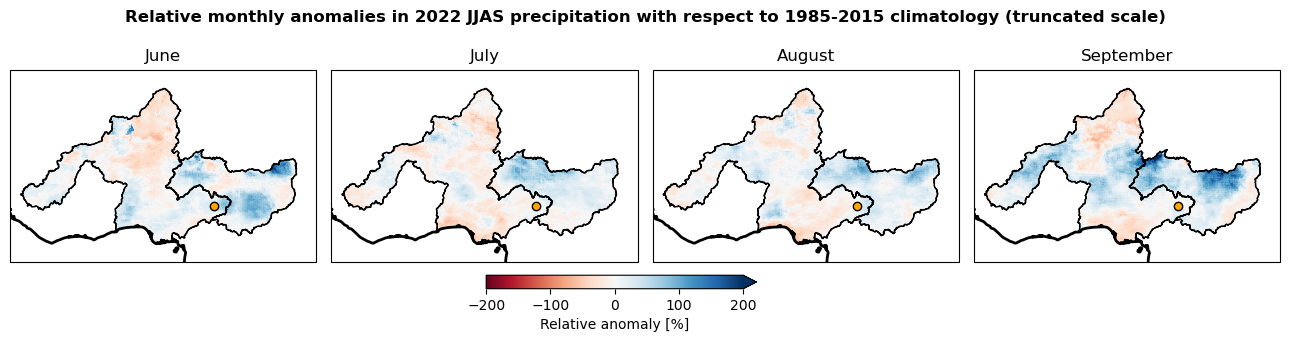

In [ ]:
pr_rel.sel(time = slice("2022-06", "2022-09")).where(rm).plot(col = "time", cmap = "RdBu", vmin = -200, vmax = 200,
                                                             subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
                                                             cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05})
for i in range(4):
    ax = plt.gcf().axes[i]
    ax.set_title(["June", "July", "August", "September"][i])
    sf.boundary.plot(ax = ax, lw = 1, color = "k")
    ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
    ax.set_extent((-13,27,2,25))
    ax.coastlines(lw = 2)
    
plt.gcf().suptitle("Relative monthly anomalies in 2022 JJAS precipitation with respect to 1985-2015 climatology (truncated scale)", fontweight = "bold")
plt.savefig("monthly-relative-anomalies-truncated.png")

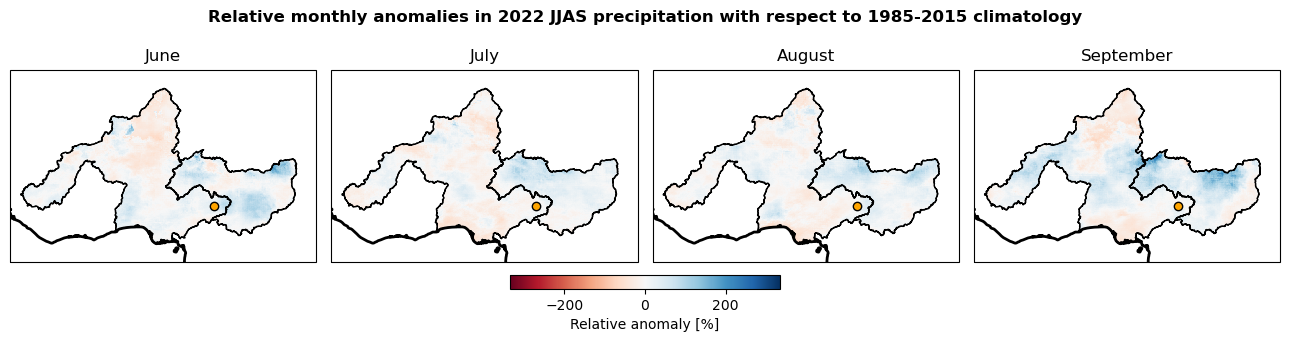

In [ ]:
pr_rel.sel(time = slice("2022-06", "2022-09")).where(rm).plot(col = "time", cmap = "RdBu",
                                                             subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
                                                             cbar_kwargs = {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05})

for i in range(4):
    ax = plt.gcf().axes[i]
    ax.set_title(["June", "July", "August", "September"][i])
    sf.boundary.plot(ax = ax, lw = 1, color = "k")
    ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
    ax.set_extent((-13,27,2,25))
    ax.coastlines(lw = 2)
    
plt.gcf().suptitle("Relative monthly anomalies in 2022 JJAS precipitation with respect to 1985-2015 climatology", fontweight = "bold")
plt.savefig("monthly-relative-anomalies.png")

#### **JJA anomalies**

In [ ]:
# get JJA seasonal precip
pr_jja =  xr.open_dataset("chirps-nigerbenue-monthly.nc").precip.sel(latitude = slice(0,25), longitude = slice(-13,27)).groupby("time.season")["JJA"].resample(time = "AS").mean()

pr_jja_clim = pr_jja.sel(time = slice("1985", "2015")).mean("time")
pr_jja_anom = pr_jja.sel(time = "2022") - pr_jja_clim
pr_jja_rel = pr_jja_anom / pr_jja_clim * 100

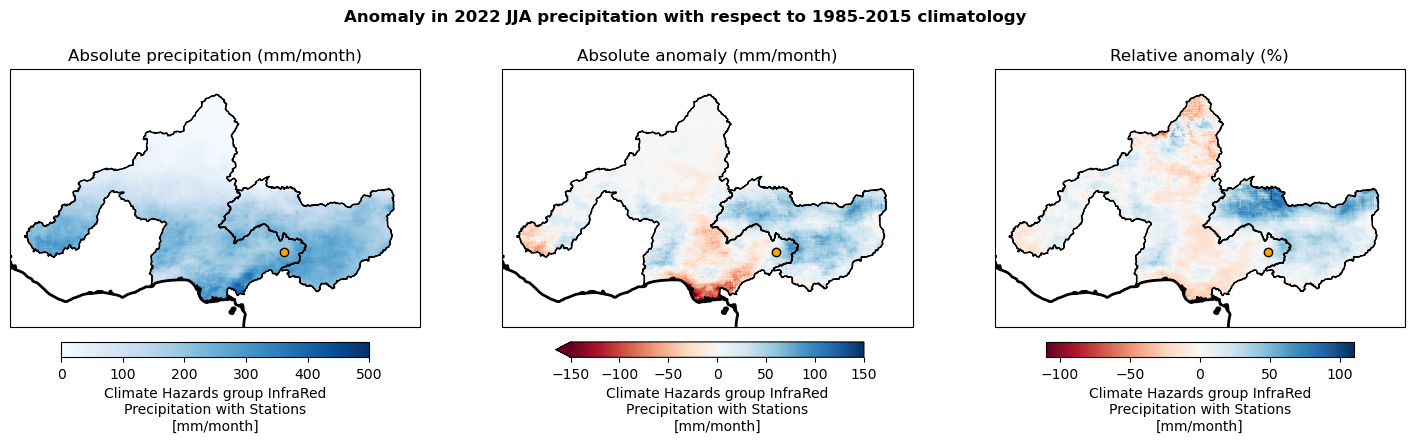

In [ ]:
# plot JJA precip & anomaly
sf = pd.concat([gpd.read_file("niger-benue-catchment"), gpd.read_file("lake-chad-catchment")])
rm = regionmask.mask_3D_geopandas(sf.dissolve(), pr_jja_anom.longitude, pr_jja_anom.latitude, drop = False).squeeze(drop = True)

fig, axs = plt.subplots(ncols = 3, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (18,4), dpi = 100)

kw = {"cbar_kwargs" : {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05}}

pr_jja.sel(time = "2022").where(rm == 1).plot(ax = axs[0], cmap = "Blues", vmax = 500, **kw); axs[0].set_title("Absolute precipitation (mm/month)")
pr_jja_anom.where(rm == 1).plot(ax = axs[1], cmap = "RdBu", vmax = 150, **kw); axs[1].set_title("Absolute anomaly (mm/month)")
pr_jja_rel.where(rm == 1).plot(ax = axs[2], cmap = "RdBu", vmax = 110, **kw); axs[2].set_title("Relative anomaly (%)")

for ax in axs: 
    sf.boundary.plot(ax = ax, lw = 1, color = "k")
    ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
    ax.set_extent((-13,27,2,25))
    ax.coastlines(lw = 2)
    
fig.suptitle("Anomaly in 2022 JJA precipitation with respect to 1985-2015 climatology", fontweight = "bold")

plt.savefig("jja2022-precipitation.png")

#### **JJAS anomalies**

In [ ]:
# get JJAS seasonal precip
pr_jjas =  xr.open_dataset("chirps-nigerbenue-monthly.nc").precip.sel(longitude = slice(-13,27))
pr_jjas = pr_jjas.sel(time = [t.dt.month in [6,7,8,9] for t in pr_jjas.time]).resample(time = "AS").mean()

pr_jjas_clim = pr_jjas.sel(time = slice("1985", "2015")).mean("time")
pr_jjas_anom = pr_jjas.sel(time = "2022") - pr_jjas_clim
pr_jjas_rel = pr_jjas_anom / pr_jjas_clim * 100

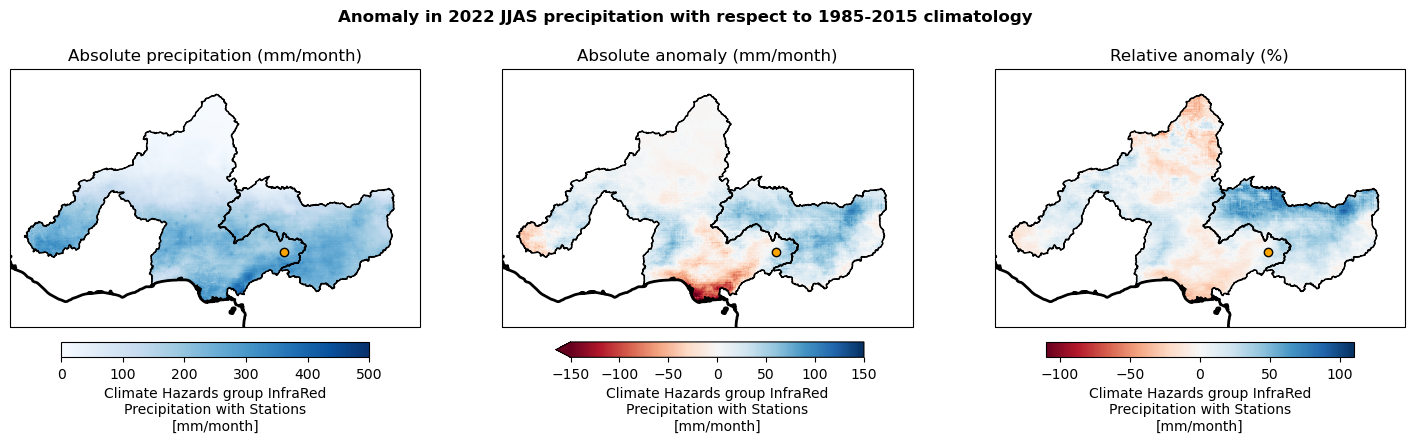

In [ ]:
# plot JJAS precip & anomaly
sf = pd.concat([gpd.read_file("niger-benue-catchment"), gpd.read_file("lake-chad-catchment")])
rm = regionmask.mask_3D_geopandas(sf.dissolve(), pr_jjas_anom.longitude, pr_jjas_anom.latitude, drop = False).squeeze(drop = True)

fig, axs = plt.subplots(ncols = 3, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (18,4), dpi = 100)

kw = {"cbar_kwargs" : {"location" : "bottom", "fraction" : 0.05, "pad" : 0.05}}

pr_jjas.sel(time = "2022").where(rm == 1).plot(ax = axs[0], cmap = "Blues", vmax = 500, **kw); axs[0].set_title("Absolute precipitation (mm/month)")
pr_jjas_anom.where(rm == 1).plot(ax = axs[1], cmap = "RdBu", vmax = 150, **kw); axs[1].set_title("Absolute anomaly (mm/month)")
pr_jjas_rel.where(rm == 1).plot(ax = axs[2], cmap = "RdBu", vmax = 110, **kw); axs[2].set_title("Relative anomaly (%)")

for ax in axs: 
    sf.boundary.plot(ax = ax, lw = 1, color = "k")
    ax.plot(*get_latlon("Lagdo Dam").values(), marker = "o", mec = "k", color = "orange")
    ax.set_extent((-13,27,2,25))
    ax.coastlines(lw = 2)

fig.suptitle("Anomaly in 2022 JJAS precipitation with respect to 1985-2015 climatology", fontweight = "bold")
plt.savefig("jjas2022-precipitation.png")

---
### **Time series for each catchment**

In [ ]:
pr = xr.open_dataset("../01_chirps/chirps-daily-p25.nc").precip.sel(latitude = slice(0,25), longitude = slice(-13,27))

# save daily mean precip in each catchment as time series
[pr.where(regionmask.mask_3D_geopandas(gpd.read_file(fnm), pr.longitude, pr.latitude).squeeze(drop = True)).mean(["latitude", "longitude"]).to_netcdf(re.sub("-catchment", "_chirps-daily-p25.nc", fnm)) 
 for fnm in glob.glob("*-catchment")]

#### **Seasonal cycle at different accumulations**

In [2]:
pr_nb = xr.open_dataset("niger-benue_chirps-daily-p25.nc").precip
pr_chad = xr.open_dataset("lake-chad_chirps-daily-p25.nc").precip
pr_lagdo = xr.open_dataset("lagdo-dam_chirps-daily-p25.nc").precip

In [6]:
labelticks = [i for i in range(366) if pr_nb.sel(time = slice("20180101", "20190101")).time.dt.day[i] == 1]
labels = [pr_nb.sel(time = slice("20180101", "20190101")).time[i].values for i in range(366) if pr_nb.sel(time = slice("20180101", "20190101")).time.dt.day[i] == 1]

for ndays in [1,3,5,7,15,30,60,90,120]:
    
    fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, sharey = False)
    
    for i in range(2):
        ax = axs[i]
        ts = [pr_chad, pr_nb][i].rolling(time = ndays, center = False).mean()
        cmt = ["Lake Chad catchment", "Niger-Benue catchment"][i]
        
        # plot each year individually so that the overlapping transparencies interact
        for y in set(ts.time.dt.year.values): 
            ax.plot(ts.sel(time = str(y)).time.dt.dayofyear, ts.sel(time = str(y)), color = "tab:blue", alpha = 0.3)
        ax.plot(ts.sel(time = "2022").time.dt.dayofyear, ts.sel(time = "2022"), color = "k", label = "2022")
        ax.legend(edgecolor = "w")
        ax.set_title(cmt)
        
        ax.set_xticks(labelticks)
        ax.set_xticklabels(labels)
        ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b"))
        ax.set_ylabel("Mean daily rate (mm/day)")
        ax.grid(axis = "x", alpha = 0.5, ls = "--")
        
    # axs[2].axvline(pr_lagdo.sel(time = "20180920").time.dt.dayofyear.values, ls = "--", color = "red", alpha = 0.4) # opening of the dam
    
    fig.suptitle("Mean daily rate of "+str(ndays)+"-day accumulated precipitation in 2022 compared to previous years", fontweight = "bold", y = 1.02)
    plt.savefig(str(ndays)+"-day-precip.png"); plt.close()

#### **JJAS total precip**

In [3]:
pr_nb = xr.open_dataset("niger-benue_chirps-daily-p25.nc").precip
pr_chad = xr.open_dataset("lake-chad_chirps-daily-p25.nc").precip
pr_lagdo = xr.open_dataset("lagdo-dam_chirps-daily-p25.nc").precip

jjas_nb, jjas_chad, jjas_lagdo = [ts.sel(time = [m in [6,7,8,9] for m in ts.time.dt.month]).resample(time = "AS").mean() for ts in [pr_nb, pr_chad, pr_lagdo]]

In [44]:
# save JJAS time seriesas txt for upload to Climate Explorer
jjas_nb.assign_coords(time = jjas_nb.time.dt.year).rename(time = "#year").to_dataframe().to_csv("ts/niger-benue_chirps-daily-p25.txt", sep = " ")
! echo "# niger-benue_jjas" >> ts/niger-benue_chirps-daily-p25.txt

jjas_chad.assign_coords(time = jjas_chad.time.dt.year).rename(time = "#year").to_dataframe().to_csv("ts/lake-chad_chirps-daily-p25.txt", sep = " ")
! echo "# lake_chad_jjas" >> ts/lake-chad_chirps-daily-p25.txt

jjas_lagdo.assign_coords(time = jjas_lagdo.time.dt.year).rename(time = "#year").to_dataframe().to_csv("ts/lagdo-dam_chirps-daily-p25.txt", sep = " ")
! echo "# lagdo_dam_jjas" >> ts/lagdo-dam_chirps-daily-p25.txt

Text(0.5, 1.01, 'Distribution of CHIRPS JJAS total precipitation')

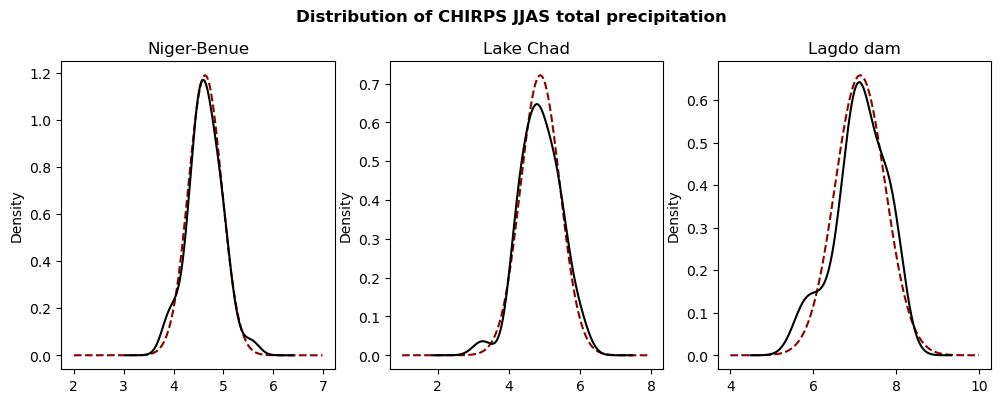

In [37]:
# density plots
fig, axs = plt.subplots(ncols = 3, figsize = (12,4), dpi = 100)

for i in range(3):
    ax = axs[i]
    ts = [jjas_nb, jjas_chad, jjas_lagdo][i]
    cmt = ["Niger-Benue", "Lake Chad", "Lagdo dam"][i]
    
    pd.DataFrame(ts.values).plot.density(ax = ax, color = "k", zorder = 100)
    
    xlim = ax.get_xlim()
    x = np.arange(np.floor(xlim[0]), np.ceil(xlim[1]), 0.01)
    y = norm.pdf(x, ts.mean(), ts.std())
    
    ax.plot(x, y, color = "darkred", ls = "--")
    ax.legend("", edgecolor = "w")
    ax.set_title(cmt)
    
fig.suptitle("Distribution of CHIRPS JJAS total precipitation", fontweight = "bold", y = 1.01)

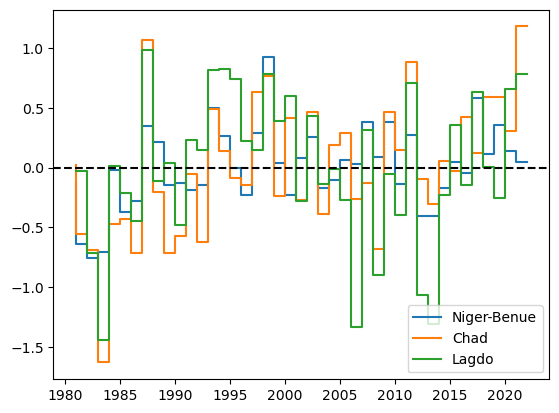

In [49]:
plt.step(jjas_nb.time, jjas_nb - jjas_nb.mean(), label = "Niger-Benue")
ax = plt.gcf().axes[0]
ax.step(jjas_chad.time, jjas_chad - jjas_chad.mean(),label = "Chad")
ax.step(jjas_lagdo.time, jjas_lagdo - jjas_lagdo.mean(), label = "Lagdo")
ax.axhline(0, ls = "--", color = "k")
ax.legend()

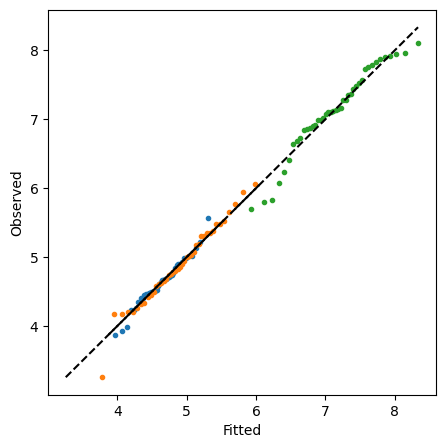

In [8]:
fig, ax = plt.subplots(figsize = (5,5), dpi = 100)

qqplot(jjas_nb, ax = ax, label = "Niger-Benue")
qqplot(jjas_chad, ax = ax, label = "")
qqplot(jjas_lagdo, ax = ax)


---
## **Earlier noodlings**

---
### **Maps of monthly mean precipitation**

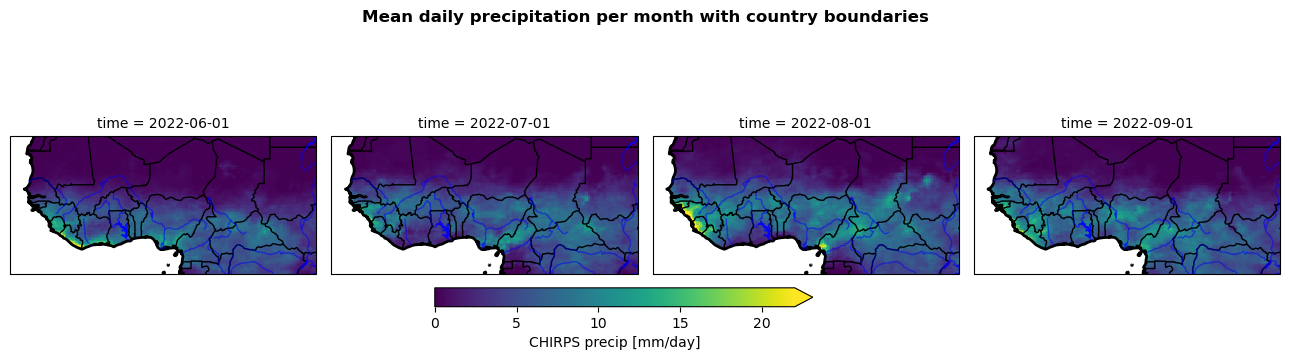

In [30]:
pr.resample(time = "MS").mean().plot(col = "time", subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
                                     cbar_kwargs = {"location" : "bottom", "fraction" : 0.07, "pad" : 0.05}, cmap = "viridis", vmax = 22)

# coastlines and country borders
for ax in plt.gcf().axes[:4]:
    
    ax.coastlines(lw = 2)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
    ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.5)
    
plt.suptitle("Mean daily precipitation per month with country boundaries", y = 1.04, fontweight = "bold")

plt.savefig("JJAS-precip-with-countries.png")

In [31]:
for l in [2,3,4]:
    
    pr.resample(time = "MS").mean().plot(col = "time", subplot_kws = {"projection" : cartopy.crs.PlateCarree()},
                                     cbar_kwargs = {"location" : "bottom", "fraction" : 0.07, "pad" : 0.05}, cmap = "viridis", vmax = 22)
    
    sf = gpd.read_file("hybas_af_lev01-12_v1c/lev0"+str(l)).to_crs(cartopy.crs.PlateCarree())
    
    # rivers and river basins
    for ax in plt.gcf().axes[:4]:
        
        sf.boundary.plot(ax = ax, color = "k", lw = 0.5)
        ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
        ax.add_feature(cartopy.feature.LAKES, color = "blue", alpha = 0.5)
        
        ax.set_extent(subregion["lon"] + subregion["lat"])
        
    plt.suptitle("Mean daily precipitation per month with 'level "+str(l)+"' river basins", y = 1.06, fontweight = "bold")
    plt.savefig("JJAS-precip-with-lvl"+str(l)+"-river-basins.png"); plt.close()

---
### **Time series in selected catchment**

In [2]:
# load chirps, select single year for a subregion over N/C Africa to speed things up
subregion = {"lat" : [0,24], "lon" : [-20,33]}
pr =  xr.open_dataset("../01_chirps/chirps-daily-p25.nc").sel(longitude = slice(subregion["lon"][0], subregion["lon"][1]),
                                                              latitude = slice(subregion["lat"][0], subregion["lat"][1])).precip.load()

pr = pr.assign_attrs(long_name = "CHIRPS precip") # for colourbar

In [3]:
# load shapefile & create regionmask
sf_flood = gpd.read_file("nigeria-flood-region")
rm = regionmask.mask_3D_geopandas(sf_flood, pr.longitude, pr.latitude, drop = False).squeeze(drop = True)

In [4]:
ts = pr.where(rm).mean(["latitude", "longitude"])
ts.to_netcdf("chirps-daily-basinmean.nc")

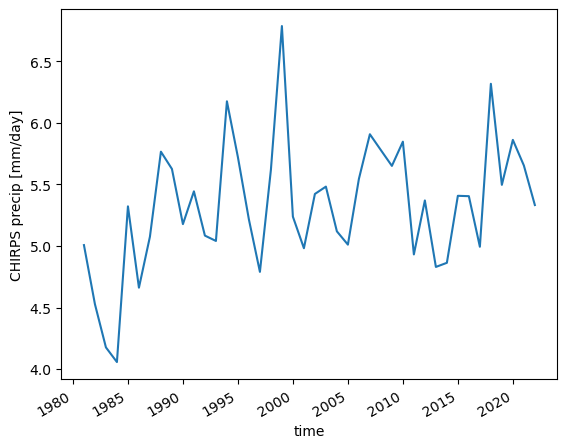

In [16]:
pr_max = ts.rolling(time = 60).mean().resample(time = "AS").max()
pr_max.plot()

plt.savefig("annual-maxima-of-60day-rolling-mean-precip.png")

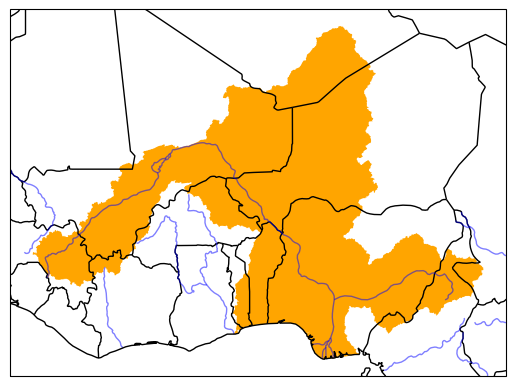

In [6]:
fig, ax = plt.subplots(subplot_kw = { "projection" : cartopy.crs.PlateCarree()})
sf_flood.plot(ax = ax, color = "orange")

ax.add_feature(cartopy.feature.BORDERS, color = "k")
ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)

ax.coastlines()

In [7]:
def cx_csv(da, fnm = None, dataset = None):
    
    # write CSV for easy import into Climate Explorer
    
    rnm = da.run.values[0]
    da = da.squeeze(drop = True)
    fnm_string = da.name+"_"+re.sub(" ", "_", rnm)
    
    if dataset is not None:
        fnm_string = dataset+"_"+fnm_string
        
    if fnm is None:
        fnm = "ts/"+fnm_string
    
    if "time" in da.dims:
        da = da.assign_coords(time = da.time.dt.year).rename(time = "#time")
    elif "year" in da.dims:
        da = da.rename(year = "#time")
    else:
        print(da.dims)
        return

    # write to csv
    fnm = re.sub(".txt", "", fnm)+".txt"
    da.to_dataframe().to_csv(fnm, sep = " ")
    
    # add a text string specifying the units (don't think format is correct here)
    if "units" in da.attrs:
        unit_string = "# "+da.name+" ["+da.units+"]"
        unit_string = "# variable ["+da.units+"]"
        ! echo "$unit_string" >> $fnm
    
    # add a line specifying the model & variable name, to be used as filename when uploading
    fnm_string = "# "+fnm_string
    ! echo "$fnm_string" >> $fnm

In [15]:
pr_max.assign_coords(time = pr_max.time.dt.year).rename(time = "#year").to_dataframe().to_csv("60daymaxprecip_basinmean.txt", sep = " ")

### **Standardised precipitation index**

In [8]:
import sys; sys.path.append('/home/clair/WWA'); from wwa import *
from xclim.indices.stats import fit
from scipy.stats import gamma, norm

import warnings
warnings.filterwarnings("ignore", message = "facecolor will have no effect.+")

In [22]:
# load monthly chirps data (already subsetted on Imperial servers)
pr = xr.open_dataset("chirps-nigeriaflooding-monthly.nc").precip.assign_attrs(long_name = "CHIRPS precip")

In [23]:
# # load shapefile & create hi-res regionmask for use with monthly data (only needs to be done once)
# sf_flood = gpd.read_file("nigeria-flood-region")
# rm = regionmask.mask_3D_geopandas(sf_flood, pr.longitude, pr.latitude, drop = False).squeeze(drop = True)
# rm.to_netcdf("regionmask-basin3-hires.nc")
rm = xr.open_dataset("regionmask-basin3-hires.nc").mask

In [83]:
# use inbuilt regionmask to get regionmask for Nigeria alone
gdf = regionmask.defined_regions.natural_earth_v5_0_0.countries_50.to_geodataframe()
rm_nigeria = regionmask.mask_3D_geopandas(gdf.loc[gdf.names == "Nigeria"], pr.longitude, pr.latitude, drop = False).squeeze(drop = True)

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1983: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/pygeos/io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [100]:
pr_nigeria = pr.where(rm_nigeria).dropna("latitude", "all").dropna("longitude", "all")

In [85]:
def get_spi(da, start_cal = "1985", end_cal = "2015", min_precip = 30):
    
    spi = []
    for i in range(12):
        
        pr_m = da.groupby("time.month")[i+1]
        
        pr_cal = pr_m.sel(time = slice(start_cal, end_cal)).copy()
        pr_cal = pr_cal.where((pr_cal >= 1).sum("time") >= min_precip)    # only include cells where monthly precipitation > 1mm for at least [min_precip] of the available years (removes arid regions)
        
        pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")     # use xclim to do the fitting: produces a map of the parameters. Use PWM as more robust & faster
        
        spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_m, pars, 
                               input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_m.time)
        spi.append(spi_m)
    
    spi = xr.concat(spi, "time").sortby("time").rename("spi")
    return spi

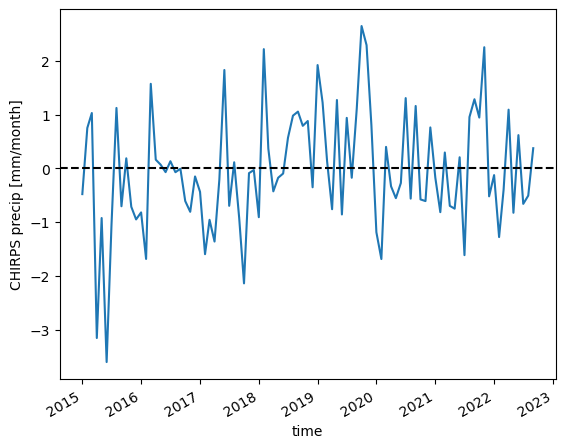

In [102]:
spi1_nigeria_ts = get_spi(pr_nigeria.mean(["latitude", "longitude"]))

spi1_nigeria_ts.sel(time = slice("2015", None)).plot()
plt.axhline(0, ls = "--", color = "k")

(array([1., 0., 0., 2., 4., 3., 4., 6., 8., 3.]),
 array([111.645134, 119.88419 , 128.12325 , 136.3623  , 144.60136 ,
        152.84042 , 161.07948 , 169.31853 , 177.55759 , 185.79665 ,
        194.0357  ], dtype=float32),
 <BarContainer object of 10 artists>)

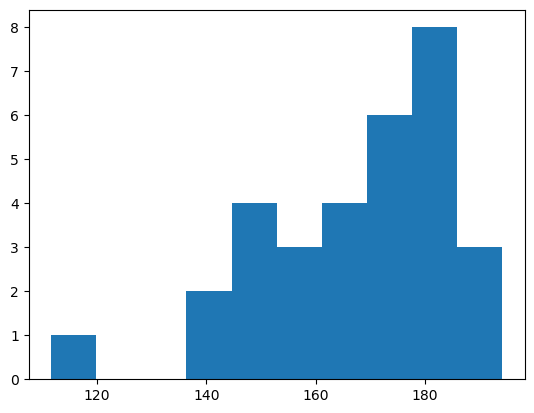

In [108]:
# is a gamma distribution even the right fit?

plt.hist(pr_nigeria.mean(["latitude", "longitude"]).sel(time = slice("1985", "2015")).groupby("time.month")[6])

In [ ]:
spi1_nigeria = get_spi(pr_nigeria)

In [120]:
nigeria_clim = pr_nigeria.sel(time = slice("1985", "2015")).groupby("time.month").mean()
nigeria_anom = (pr_nigeria.groupby("time.month") - nigeria_clim).groupby("time.month") / nigeria_clim * 100

In [126]:
nigeria_anom.sel(time = slice("2022-05", None)).plot(col = "time", cmap = "RdBu")

Text(0.5, 1.0, '')

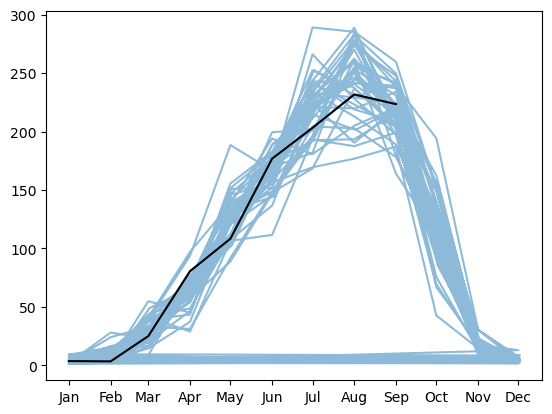

In [155]:
plt.plot(pr_nigeria.time.dt.dayofyear, pr_nigeria.mean(["latitude", "longitude"]), alpha = 0.5)
plt.plot(pr_nigeria.sel(time = "2022").time.dt.dayofyear, pr_nigeria.mean(["latitude", "longitude"]).sel(time = "2022"), color = "k")

plt.xticks(ticks = pr_nigeria.sel(time = "2018").time.dt.dayofyear.values, labels = pr_nigeria.sel(time = "2018").time.values)
import matplotlib.dates as mdates; plt.gcf().axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%b"))

plt.title("")

In [11]:
# monthly climatology
pr_clim = pr.sel(time = slice("1985", "2015")).groupby("time.month").mean()

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/pygeos/io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [4]:
pr_anom_abs = pr.groupby("time.month") - pr_clim

In [24]:
pr_anom_rel = pr_anom_abs.sel(time = slice("2022-04", None)).groupby("time.month") / pr_clim

#### **SPI of aggregated precipitation**

In [ ]:
# average precip over proposed study region
pr1 = pr.where(rm == 1).mean(["latitude", "longitude"])

spi = []
for i in range(12):
    
    pr_m = pr1.groupby("time.month")[i+1]
    
    pr_cal = pr_m.sel(time = slice("1985", "2015")).copy()
    pr_cal = pr_cal.where((pr_cal >= 1).sum("time") >= 30)    # only include cells where monthly precipitation > 1mm for at least 30 of the available years (removes arid regions)
    
    pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")     # use xclim to do the fitting: produces a map of the parameters. Use PWM as more robust & faster
    
    spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_m, pars, 
                                    input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_m.time)
    spi.append(spi_m)
spi = xr.concat(spi, "time").sortby("time").rename("spi")

In [55]:
# what about 4-month average precip?
pr4 = pr.rolling(time = 4, center = False).mean().where(rm == 1).mean(["latitude", "longitude"])

spi4 = []
for i in range(12):
    
    pr_m = pr4.groupby("time.month")[i+1]
    
    pr_cal = pr_m.sel(time = slice("1985", "2015")).copy()
    pr_cal = pr_cal.where((pr_cal >= 1).sum("time") >= 30)    # only include cells where monthly precipitation > 1mm for at least 30 of the available years (removes arid regions)
    
    pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")     # use xclim to do the fitting: produces a map of the parameters. Use PWM as more robust & faster
    
    spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_m, pars, 
                                    input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_m.time)
    spi4.append(spi_m)
    
spi4 = xr.concat(spi4, "time").sortby("time").rename("spi")

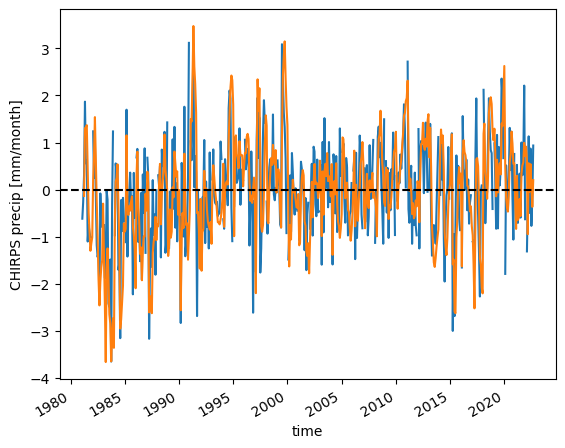

In [57]:
spi.plot()
spi4.plot()

# spi.sel(time = "2022").plot(marker = ".")
plt.axhline(0, color = "k", ls = "--")

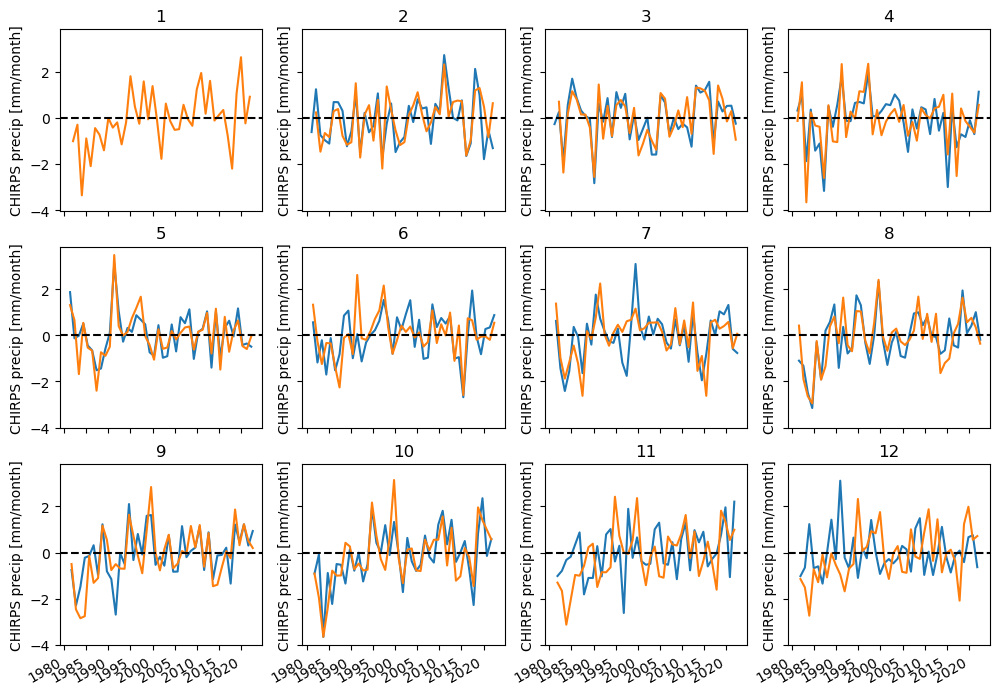

In [63]:
fig, axs = plt.subplots(ncols = 4, nrows = 3, figsize = (12,8), sharex = True, sharey = True)

for i in range(12):
    
    ax = plt.gcf().axes[i]
    spi.groupby("time.month")[i+1].plot(ax = ax)
    spi4.groupby("time.month")[i+1].plot(ax = ax)

    ax.axhline(0, ls = "--", color = "k")
    
    ax.set_title(i+1)
    ax.set_xlabel("")

#### **Maps of SPI**

In [11]:
# consider 1-month precip, over river basin only
pr1 = pr.where(rm == 1).dropna("latitude", "all").dropna("longitude", "all")

spi = []
for i in range(12):
    
    pr_m = pr1.groupby("time.month")[i+1]
    
    pr_cal = pr_m.sel(time = slice("1985", "2015")).copy()
    pr_cal = pr_cal.where((pr_cal >= 1).sum("time") >= 30)    # only include cells where monthly precipitation > 1mm for at least 30 of the available years (removes arid regions)
    
    pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")     # use xclim to do the fitting: produces a map of the parameters. Use PWM as more robust & faster
    
    spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_m, pars, 
                                    input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_m.time)
    
    spi.append(spi_m)

In [ ]:
zz = xr.concat(spi, "time").sortby("time").rename("spi")
zz.to_netcdf("spi1-basin.nc")

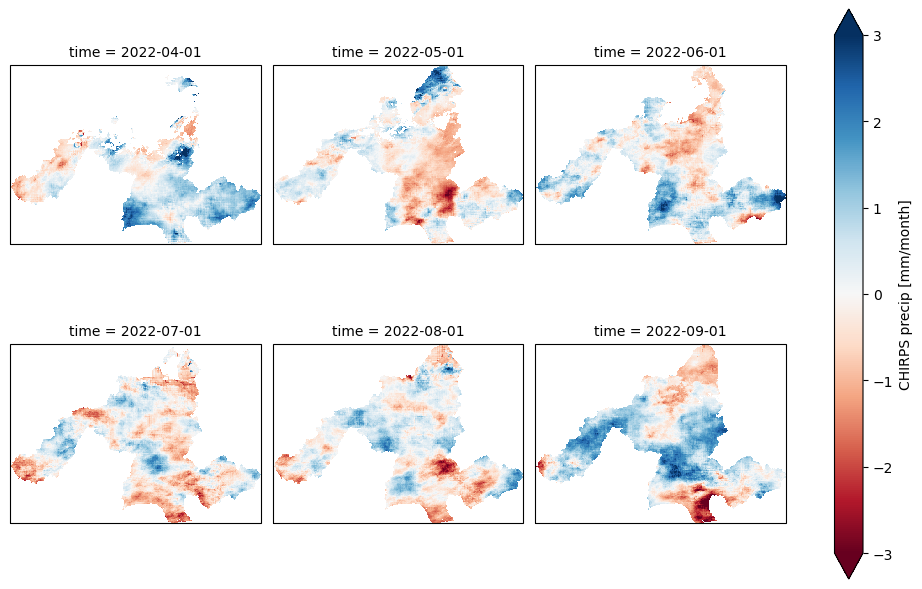

In [19]:
zz.sel(time = slice("2022-04", None)).plot(col = "time", col_wrap = 3, subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, cmap = "RdBu", vmax = 3, vmin = -3)

### **Relative anomalies**

In [1]:
# let's try something simpler. Relative monthly anomalies wrt 1985-2015 mean.
import sys; sys.path.append('/home/clair/WWA'); from wwa import *

ERROR 1: PROJ: proj_create_from_database: Open of /home/clair/miniconda3/envs/wwa/share/proj failed


In [11]:
# load monthly chirps data
pr = xr.open_dataset("chirps-nigeriaflooding-monthly.nc").precip.assign_attrs(long_name = "CHIRPS precip")
sf_flood = gpd.read_file("nigeria-flood-region")
rm = regionmask.mask_3D_geopandas(sf_flood, pr.longitude, pr.latitude, drop = False).squeeze(drop = True)
rm.to_netcdf("regionmask-basin3.nc")

In [11]:
# monthly climatology
pr_clim = pr.sel(time = slice("1985", "2015")).groupby("time.month").mean()

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/pygeos/io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry


In [4]:
pr_anom_abs = pr.groupby("time.month") - pr_clim

In [24]:
pr_anom_rel = pr_anom_abs.sel(time = slice("2022-04", None)).groupby("time.month") / pr_clim

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/cartopy/mpl/style.py:76: Us

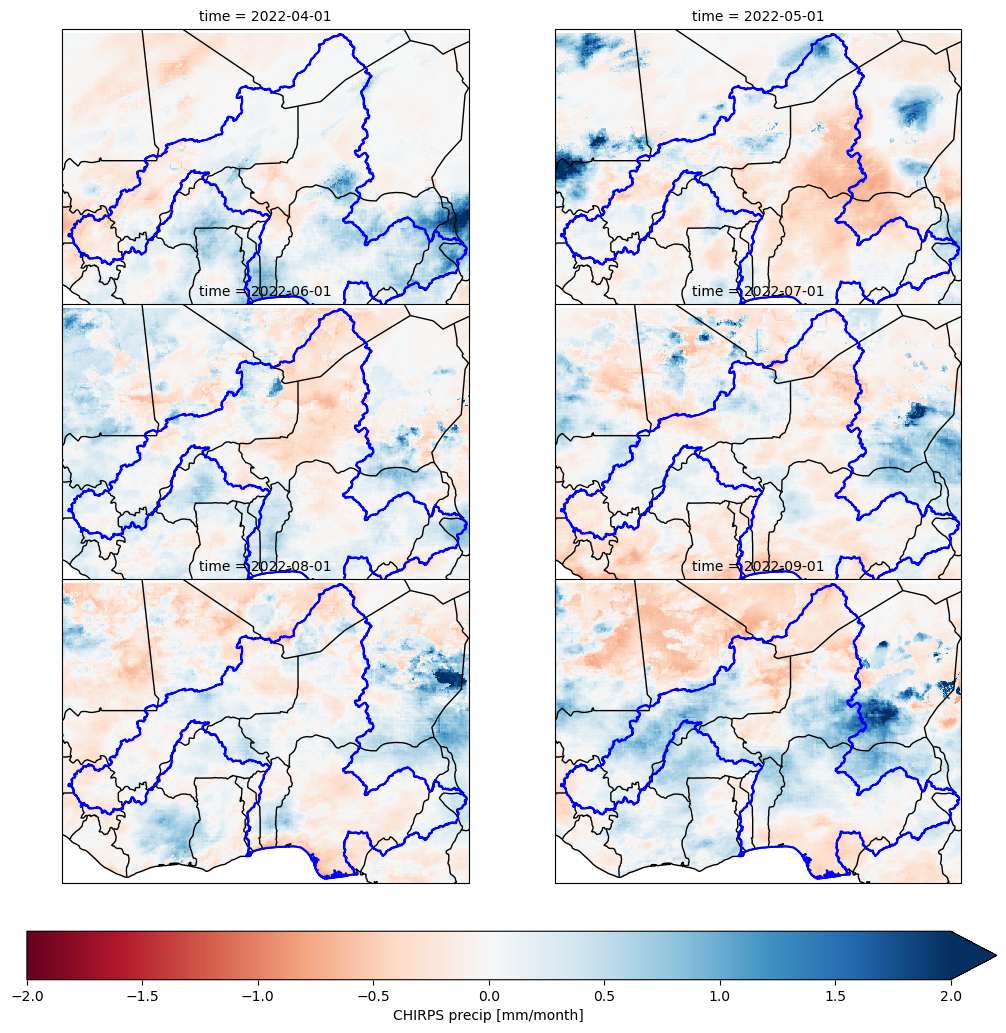

In [25]:
pr_anom_rel.plot(subplot_kws = {"projection" : cartopy.crs.PlateCarree()}, col = "time", cmap = "RdBu", col_wrap = 2, vmin = -2, vmax = 2,
                           cbar_kwargs = {"location" : "bottom", "fraction" : 0.07, "pad" : 0.05}, figsize = (10,10))

for ax in plt.gcf().axes[:-1]:
    
    sf_flood.boundary.plot(ax = ax, color = "blue")
    
    ax.add_feature(cartopy.feature.BORDERS, color = "k")
    # ax.add_feature(cartopy.feature.RIVERS, color = "blue", alpha = 0.5)
    
    ax.coastlines()
    ax.set_extent((-12,16,4,24))